# Part 1: Imports + Setup

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import os

# Part 2: Defining the Network

In [3]:
class EmojifyNet(nn.Module):
    def __init__(self):
        super(EmojifyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)
        self.mxpl1 = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.mxpl2 = nn.MaxPool2d(3, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.mxpl3 = nn.MaxPool2d(3, 2)
        self.conv4 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.mxpl4 = nn.MaxPool2d(3, 2)
        self.conv5 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.mxpl5 = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(576, 10)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        X = self.mxpl1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.mxpl2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.mxpl3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.mxpl4(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    def load_model(self, file_path):
        self.load_state_dict(torch.load(file_path))

In [4]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

# Part 3: Loading Data + Augmentation

Training Examples: 28709
Testing Examples: 7178
<class 'torch.Tensor'>
3


TypeError: Invalid shape (3, 48, 48) for image data

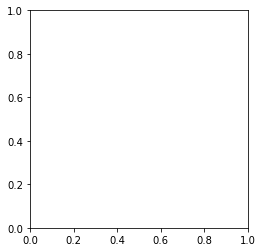

In [19]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

data_train = datasets.ImageFolder(root="../data/train", transform=transform_train)
data_test = datasets.ImageFolder(root="../data/test", transform=transform_test)

print(f"Training Examples: {len(data_train)}")
print(f"Testing Examples: {len(data_test)}")  # Dataset said we should have 3589 examples, yet we have x2 - duplicates??

print(type(data_train[0][0]))
print(len(data_train[0][0]))
plt.imshow(np.squeeze(data_train[0][0]))

# Part 4: Training the Network

In [ ]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 512
TEST_BATCH_SIZE = 10
EPOCHS = 20
LEARNING_RATE = 0.2
MOMENTUM = 0
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0

EXPERIMENT_VERSION = "bestv2" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = CifarNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    # model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')